In [1]:
import numpy as np
import json
from pathlib import Path
from os import listdir,getcwd,chdir,mkdir
chdir(str(Path('..//')))

In [2]:


from os.path import isfile,join,exists
import sys
sys.path.append(join(getcwd(),str(Path('src'))))
sys.path.append(join(getcwd(),str(Path('src/compression_funcs'))))
sys.path.append(join(getcwd(),str(Path('src/DataLoader'))))
sys.path.append(join(getcwd(),str(Path('src/Optimizer'))))
import glob
import radam
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import Data_utils
# import chebyshev_compression as cheb
# import Adaptive_chebyshev_tests as cheb_tests
# import Adaptive_chebyshev as adp_cheb
# import Company_Loader as company_data_loader
# import MIT_BIH_Loader as ecg_data_loader
# import wfdb
# import REDD_Loader as power_data_loader
import scipy
%matplotlib inline
print(getcwd())
from MISC.stats_utils import calc_statistics
sys.path.append(join(getcwd(),str(Path('src/Enviroments/ExternalEnv/BioSPPy'))))
# from LossyLessCompression import LossyLessCompression
# from Enviroments.ExternalEnv.BioSPPy import main
# from Enviroments.ExternalEnv.BioSPPy.biosppy.signals import ecg
from MISC.stats_utils import calc_loss_percentage_single,normelize_data,calc_PRD,calc_PRD_matrices
from MISC.extra_utils import reshapeECG_data
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
from torch.utils import data
# from torch.utils.tensorboard import SummaryWriter
import MIT_BIH_Loader as mit_bih_loader
import random
# from MIT_BIH_Loader import Dataset_MITBIH
from Company_Loader import Dataset
# from wfdb import processing
# from Company_ENV_Loader import Dataset_ENV
# from scipy.interpolate import interp1d
# import copy
# from torchsummary import summary
# wfdb.dl_database('mitdb', os.path.join(os.getcwd(), 'Data/mitdb'))
# cudnn.benchmark = True
pd.set_option('display.max_colwidth',10000)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device

/home/welad1992/thesis


In [3]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv1D, Flatten, Lambda,MaxPool1D,BatchNormalization,UpSampling1D,Dropout
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
# import keras

In [4]:
from Enviroments.ExternalEnv.EcgClassification.ecg import network,network_compression,network_compression_IoT
import Enviroments.ExternalEnv.EcgClassification.ecg.load as load
import Enviroments.ExternalEnv.EcgClassification.ecg.util as util

In [5]:
company_path_csv = join(getcwd(),str(Path(r'Data/TheCompany/csv/temp_company.csv')))
company_path_bin_decompressed = join(getcwd(),str(Path(r'Data/TheCompany/decompressed')))
company_path_bin = join(getcwd(),str(Path(r'Data/TheCompany')))

mit_bih_bin = join(getcwd(),str(Path(r'Data/mitdb')))
gas_path_bin = join(getcwd(),str(Path(r'Data/GAS')))
REDD_path_csv = join(getcwd(),str(Path(r'Data/REDD')))
TENSORBOARD_DIR = join(getcwd(),str(Path(r'Data/tensorsumery')))
data_path = company_path_bin
FACTOR = 4
WINDOW_SIZE = 2000

## SPLIT data

In [6]:
split_files_dir = join(getcwd(),str(Path(r'Data/MITBIH_split')))

In [7]:
BATCH_SIZE = 32
params = {'batch_size': BATCH_SIZE,
          'shuffle': True,
          'num_workers': 8}
# Datasets
# data_set = pd.read_csv('bcg_env_dataset.csv')

dir_list = glob.glob(split_files_dir+'/*.dat') #remember to normelize the data and change the data_path
print("size of dataset: ", len(dir_list))
train,val = train_test_split(dir_list,test_size=0.05,random_state=10)
print('train:',len(train),'test:',len(val))
partition = {'train': train, 'validation': val}
# Generators
training_set = Dataset(partition['train'],train,'float32',(0,1))
training_generator = data.DataLoader(training_set, **params)

validation_set = Dataset(partition['validation'], val,'float32',(0,1))
validation_generator = data.DataLoader(validation_set, **params)
# partition

size of dataset:  5184
train: 4924 test: 260


In [8]:
def load_data(Dataloader):
    i = 0
    data = None
    for local_batch, local_labels in Dataloader:
        if local_batch.size()[0]<BATCH_SIZE:
            continue
#         local_batch = local_batch.view(BATCH_SIZE,1,WINDOW_SIZE).to(device)
#         print(local_batch.numpy().shape)
        if type(data)==type(None):
            data = local_batch.numpy()
        else:
            data = np.concatenate([data, local_batch.numpy()])
        i=i+1
    print(i)
    return data
x_test_pre = load_data(validation_generator)
x_train_pre = load_data(training_generator)
# x_train_pre.shape,x_test_pre.shape

# (x_train, y_train), (x_test, y_test) = (x_train_pre,x_train_pre),(x_test_pre,x_test_pre)

# image_size = x_train.shape[1]
# x_train = np.reshape(x_train, [-1, image_size, 1])
# x_test = np.reshape(x_test, [-1, image_size,1])
# print(x_train.shape,x_test.shape)

8
153


In [9]:
(x_train, y_train),(x_test, y_test) = (x_train_pre,x_train_pre),(x_test_pre,x_test_pre)

image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size,1])
print(x_train.shape)




(4896, 2000, 1)


## Present the adaptive 

In [10]:
CAE_16 = network_compression.build_compression_network_16CG("Models/GoodModels/CAE_MITBIH_16CG_4.834-5.328-0.000.hdf5",norm_output=False)

loading compression net weights


In [11]:
CAE_16.summary()

Model: "CAE_16CG"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 2000, 1)]         0         
_________________________________________________________________
encoder_16CG (Model)         (None, 125, 1)            133585    
_________________________________________________________________
Decoder_16CG (Model)         (None, 2000, 1)           16022638  
Total params: 16,156,223
Trainable params: 16,156,127
Non-trainable params: 96
_________________________________________________________________


In [12]:
# font_size=20
# plt.figure(figsize=(20,10))
# # plt.plot(signal)
# plt.plot(predicted_signal[0],c='orange')
# plt.xlabel('time',fontsize=font_size)
# plt.ylabel('amplitude',fontsize=font_size)
# # plt.legend(['Original','Reconstr.ucted'],fontsize=font_size)
# # plt.title('Original vs Reconstrcuted',fontsize=font_size)
# plt.title('Reconstrcuted Signal S_{r} CG=16',fontsize=font_size)
# plt.grid()

In [13]:
# low_range = 0
# high_range = 80000
# first_index = 200
# snd_index=597

# signal = x_test[first_index][low_range:high_range]
# predicted_signal = CAE_16.predict(signal.reshape(1,2000,1))[low_range:high_range]
# plt.plot(signal)
# plt.plot(predicted_signal[0])
# # print(df[(df['signal_idx']==first_index) & (df['CG_int']==32)][['accuracy','mse_loss']])
# # print("normalize mse:",mse_norm)
# plt.show()

# # signal = x_dev[snd_index][low_range:high_range]
# # predicted_signal = CAE_32.predict(x_dev[snd_index].reshape(1,8960,1))[0][0][low_range:high_range]
# # signal,predicted_signal, mse_norm = normalize_mse(signal,predicted_signal)

# # plt.plot(signal)
# # plt.plot(predicted_signal)
# # print(df[(df['signal_idx']==snd_index) & (df['CG_int']==32)][['accuracy','mse_loss']])
# # print("normalize mse:",mse_norm)
# # plt.show()

In [14]:
CAE_64 = network_compression.build_compression_network_64CG("Models/GoodModels/CAE_MITBIG_64CG_8.062-7.629-0.001.hdf5",norm_output=True)
CAE_32 = network_compression.build_comression_network_32CG("Models/GoodModels/CAE_MITBIH_32CG_6.578-5.686-0.001.hdf5",norm_output=True)
CAE_16 = network_compression.build_compression_network_16CG("Models/GoodModels/CAE_MITBIH_16CG_4.834-5.328-0.000.hdf5",norm_output=False)
model_u_net = network_compression.u_net_16_32('Models/Progressive/U_NET_32-16.hdf5')
model_u_net_iot = network_compression.u_net_16_32('Models/Progressive/U_NET_32-16_iot-[4.76][6.14].hdf5',iot=True)
# model_u_unet_32_64 = network_compression_IoT.u_net_32_64('Models/Progressive/U_NET_32-64-IoT_V3.hdf5', iot=True)


loading compression net weights
loading compression net weights
loading compression net weights
loading compression net weights
loading compression net weights


In [15]:
# model_u_unet_32_64.summary()

NameError: name 'compressor' is not defined

In [18]:
raw_data = x_test

compression_methods = [CAE_16,CAE_32,CAE_64]
stats = []
for idx,signal in enumerate(raw_data):
    for compressor in compression_methods:
        decompressed = compressor.predict(signal.reshape(1,2000,1))[0]
        PRD = calc_PRD(signal,decompressed)
        stats.append([idx,signal,PRD,compressor.name])

    decompressed_16,decompressed_32 = model_u_net.predict(signal.reshape(1,2000,1))
    for decompressed,name in zip([decompressed_16[0],decompressed_32[0]],['u_net-16','u_net-32']):
        PRD = calc_PRD(signal,decompressed)
        stats.append([idx,signal,PRD,name])
        
    decompressed_16,decompressed_32 = model_u_net_iot.predict(signal.reshape(1,2000,1))
    for decompressed,name in zip([decompressed_16[0],decompressed_32[0]],['u_net-16_iot','u_net-32_iot']):
        PRD = calc_PRD(signal,decompressed)
        stats.append([idx,signal,PRD,name])
        
#     decompressed_32,decompressed_64 = model_u_unet_32_64.predict(signal.reshape(1,2000,1))
#     for decompressed,name in zip([decompressed_32[0],decompressed_64[0]],['u_net-32_iot','u_net-64_iot']):
#         PRD = calc_PRD(signal,decompressed)
#         stats.append([idx,signal,PRD,name])

In [19]:
text2num = {'CAE_32CG':32,'CAE_16CG':16,'CAE_64CG':64,'CAE_32CG_lightweight':32,'CAE_16CG_lightweight':16,'CAE_64CG_lightweight':64,'u_net-16':16,'u_net-32':32,'u_net-16_iot':16,'u_net-32_iot':32,'u_net-64_iot':64}
df = pd.DataFrame(stats)
df.columns=['signal_idx','signal','PRD','CG']
df['CG_int'] = df['CG'].apply(lambda x:text2num[x])
df.describe()

,signal_idx,PRD,CG_int
count,1792.000000,1792.000000,1792.000000
mean,127.500000,4.923777,29.714286
std,73.920899,2.821816,15.840313
min,0.000000,1.099947,16.000000
25%,63.750000,3.343863,16.000000
50%,127.500000,4.209694,32.000000
75%,191.250000,5.556546,32.000000
max,255.000000,30.630939,64.000000


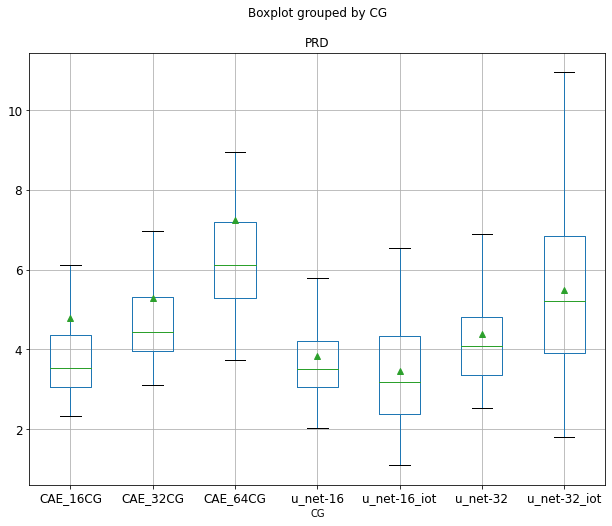

In [20]:
bp = df.boxplot('PRD',by='CG',return_type='both',showmeans=True,showfliers=False,fontsize=12,figsize=(10,8))

In [21]:
df_basic = df[(df['CG']!='u_net-16') & (df['CG']!='u_net-32') & (df['CG']!='u_net-16_iot') & (df['CG']!='u_net-32_iot')]

In [22]:
df_basic[df_basic['CG_int']<64].head()

,signal_idx,signal,PRD,CG,CG_int
0,0,"[[0.34408602], [0.34408602], [0.3373656], [0.33870968], [0.3373656], [0.3346774], [0.3360215], [0.33870968], [0.33870968], [0.33870968], [0.3360215], [0.33870968], [0.3373656], [0.3346774], [0.3346774], [0.3360215], [0.3360215], [0.3360215], [0.3373656], [0.3373656], [0.3373656], [0.3360215], [0.3346774], [0.3373656], [0.3373656], [0.33333334], [0.3346774], [0.33333334], [0.33333334], [0.3373656], [0.3373656], [0.33870968], [0.3346774], [0.3373656], [0.34005377], [0.3373656], [0.3360215], [0.33198923], [0.327957], [0.33064517], [0.33064517], [0.3346774], [0.3373656], [0.34005377], [0.34274194], [0.34139785], [0.34408602], [0.34005377], [0.3373656], [0.34005377], [0.33333334], [0.3346774], [0.3360215], [0.3346774], [0.34139785], [0.34274194], [0.3454301], [0.35080644], [0.3534946], [0.3534946], [0.35618284], [0.36021504], [0.35752687], [0.36021504], [0.36021504], [0.36021504], [0.36693552], [0.36693552], [0.37365595], [0.3763441], [0.3763441], [0.37096778], [0.36155918], [0.3534946], [0.35215053], [0.35080644], [0.3467742], [0.35080644], [0.35215053], [0.35618284], [0.35752687], [0.35618284], [0.3534946], [0.34946236], [0.34274194], [0.34005377], [0.3373656], [0.33198923], [0.3360215], [0.3360215], [0.33870968], [0.3454301], [0.34274194], [0.3534946], [0.35618284], [0.36693552], [0.37231186], [0.3857527], [0.405914], [0.436828], ...]",2.475880,CAE_16CG,16
1,0,"[[0.34408602], [0.34408602], [0.3373656], [0.33870968], [0.3373656], [0.3346774], [0.3360215], [0.33870968], [0.33870968], [0.33870968], [0.3360215], [0.33870968], [0.3373656], [0.3346774], [0.3346774], [0.3360215], [0.3360215], [0.3360215], [0.3373656], [0.3373656], [0.3373656], [0.3360215], [0.3346774], [0.3373656], [0.3373656], [0.33333334], [0.3346774], [0.33333334], [0.33333334], [0.3373656], [0.3373656], [0.33870968], [0.3346774], [0.3373656], [0.34005377], [0.3373656], [0.3360215], [0.33198923], [0.327957], [0.33064517], [0.33064517], [0.3346774], [0.3373656], [0.34005377], [0.34274194], [0.34139785], [0.34408602], [0.34005377], [0.3373656], [0.34005377], [0.33333334], [0.3346774], [0.3360215], [0.3346774], [0.34139785], [0.34274194], [0.3454301], [0.35080644], [0.3534946], [0.3534946], [0.35618284], [0.36021504], [0.35752687], [0.36021504], [0.36021504], [0.36021504], [0.36693552], [0.36693552], [0.37365595], [0.3763441], [0.3763441], [0.37096778], [0.36155918], [0.3534946], [0.35215053], [0.35080644], [0.3467742], [0.35080644], [0.35215053], [0.35618284], [0.35752687], [0.35618284], [0.3534946], [0.34946236], [0.34274194], [0.34005377], [0.3373656], [0.33198923], [0.3360215], [0.3360215], [0.33870968], [0.3454301], [0.34274194], [0.3534946], [0.35618284], [0.36693552], [0.37231186], [0.3857527], [0.405914], [0.436828], ...]",4.147525,CAE_32CG,32
7,1,"[[0.25870648], [0.252073], [0.24212274], [0.22719736], [0.21558872], [0.20563848], [0.20232174], [0.20066336], [0.20398012], [0.20398012], [0.19071311], [0.18242124], [0.17910448], [0.17910448], [0.18242124], [0.1774461], [0.1774461], [0.16749586], [0.16915423], [0.16583748], [0.1708126], [0.16749586], [0.15920398], [0.15257049], [0.1509121], [0.16252074], [0.16086237], [0.15588723], [0.14925374], [0.14925374], [0.15257049], [0.16417912], [0.17247099], [0.17247099], [0.16915423], [0.16915423], [0.1774461], [0.18407962], [0.18573798], [0.18407962], [0.18573798], [0.17910448], [0.18573798], [0.19402985], [0.1973466], [0.199005], [0.19568823], [0.199005], [0.199005], [0.20563848], [0.21227197], [0.21227197], [0.21227197], [0.2172471], [0.22056386], [0.21558872], [0.21061361], [0.20729686], [0.20563848], [0.20729686], [0.20398012], [0.20895523], [0.20729686], [0.20232174], [0.19402985], [0.18573798], [0.18407962], [0.18242124], [0.18905473], [0.19568823], [0.19402985], [0.18739636], [0.18905473], [0.18573798], [0.18739636], [0.18407962], [0.17412935], [0.16749586], [0.16915423], [0.16417912], [0.16749586], [0.16417912], [0.15920398], [0.15920398], [0.15422885], [0.15920398], [0.16417

In [27]:
num_of_samples = x_test.shape[0]
def adaptive_compression(df, threshold_PRD,base_factor=1):
    df_threshold = df[df['PRD']<threshold_PRD]
    indices = df_threshold.groupby('signal_idx',sort=False)['CG_int'].transform(max)==df_threshold['CG_int']
    
    if len(indices)==0:
        num_satisfied_PRD_indices = 0
        avg_prd = 0
        meanCG = base_factor

    else:
        num_satisfied_PRD_indices = indices.value_counts()[True]
        avg_prd = (num_satisfied_PRD_indices/num_of_samples)*df_threshold[indices]['PRD'].mean()
        meanCG = ((num_of_samples-num_satisfied_PRD_indices)/num_of_samples)*base_factor + (num_satisfied_PRD_indices/num_of_samples)*df_threshold[indices]['CG_int'].mean()
    
    return avg_prd,meanCG


static_SOTA_64={'prd':[],'cg':[],'REALPRD':[]}
static_SOTA_32={'prd':[],'cg':[],'REALPRD':[]}
static_SOTA_16={'prd':[],'cg':[],'REALPRD':[]}
adap_cg_min1_max32 = {'prd':[],'cg':[],'REALPRD':[]}
adap_cg_min1_max32_unet = {'prd':[],'cg':[],'REALPRD':[]}
adap_cg_min1_max32_unet_iot = {'prd':[],'cg':[],'REALPRD':[]}
adap_cg_min1_max64 = {'prd':[],'cg':[],'REALPRD':[]}
# adap_cg_min32 = []
for PRD in np.arange(2.2,7.5,0.2):
#     static_SOTA_16['cg'].append(adaptive_compression(df_basic[df_basic['CG_int']==16],PRD,1)[1])
#     static_SOTA_32['cg'].append(adaptive_compression(df_basic[df_basic['CG_int']==32],PRD,1)[1])
#     static_SOTA_64['cg'].append(adaptive_compression(df_basic[df_basic['CG_int']==64],PRD,1)[1])
#     adap_cg_min1_max32['cg'].append(adaptive_compression(df_basic[df_basic['CG_int']<64],PRD,1)[1])
#     adap_cg_min1_max32_unet['cg'].append(adaptive_compression(df[(df['CG']=='u_net-16') | (df['CG']=='u_net-32')],PRD,1)[1])
#     adap_cg_min1_max32_unet_iot['cg'].append(adaptive_compression(df[(df['CG']=='u_net-16_iot') | (df['CG']=='u_net-32_iot')],PRD,1)[1])
#     adap_cg_min1_max64['cg'].append(adaptive_compression(df_basic,PRD,1)[1])
    
    prd,cg = adaptive_compression(df_basic[df_basic['CG_int']==16],PRD,1)
    static_SOTA_16['prd'].append(prd)
    static_SOTA_16['cg'].append(cg)
    static_SOTA_16['REALPRD'].append(PRD)
    
    
    prd,cg = adaptive_compression(df_basic[df_basic['CG_int']==32],PRD,1)
    static_SOTA_32['prd'].append(prd)
    static_SOTA_32['cg'].append(cg)
    static_SOTA_32['REALPRD'].append(PRD)
    
#     prd,cg = adaptive_compression(df[df['CG_int']==64],PRD,1)
#     static_SOTA_64['prd'].append(prd)
#     static_SOTA_64['cg'].append(cg)
    
    prd,cg = adaptive_compression(df_basic[df_basic['CG_int']<65],PRD,1)
    adap_cg_min1_max32['prd'].append(prd)
    adap_cg_min1_max32['cg'].append(cg)
    adap_cg_min1_max32['REALPRD'].append(PRD)

#     adap_cg_min32.append(adaptive_compression(df[df['CG_int']>31],PRD,32))


Text(0.5, 1.0, 'Adaptive CG as func of PRD loss')

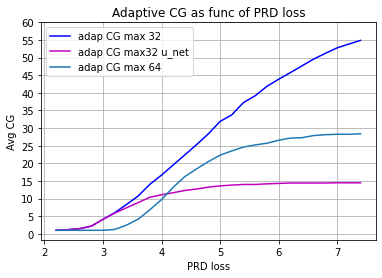

In [28]:
plt.plot(np.arange(2.2,7.5,0.2),adap_cg_min1_max32['cg'],'b')
# plt.plot(np.arange(2,10,0.2),adap_cg_min1_max32_unet['cg'],'r')
# plt.plot(np.arange(2,10,0.2),adap_cg_min1_max64['cg'],'y')
plt.plot(np.arange(2.2,7.5,0.2),static_SOTA_16['cg'],'m')
plt.plot(np.arange(2.2,7.5,0.2),static_SOTA_32['cg'])
# plt.plot(np.arange(2,10,0.2),static_SOTA_64['cg'])
plt
plt.legend(['adap CG max 32','adap CG max32 u_net','adap CG max 64','static CG=16','static CG=32','static CG=64'])
plt.yticks(np.arange(0, 65, 5))
plt.xlabel('PRD loss')
plt.ylabel('Avg CG')
plt.grid()
plt.title('Adaptive CG as func of PRD loss')

In [33]:
adap_cg_min1_max32

{'prd': [0,
  0.027556936160406394,
  0.07656493374306818,
  0.2033499646675058,
  0.5801403122400518,
  0.9434637992747132,
  1.3243188301044124,
  1.6944526307215853,
  2.1429361768623636,
  2.4520485058989863,
  2.755504020521225,
  3.1039278222568853,
  3.3223953764240832,
  3.5831339437035497,
  3.8185476527621773,
  3.9679351584366196,
  4.177211176168325,
  4.280930622880948,
  4.459853924023843,
  4.589989542044984,
  4.6982377276351235,
  4.811836327904958,
  4.951490199722011,
  5.076304880117407,
  5.23028087955038,
  5.311227570667167,
  5.397160639798871],
 'cg': [1,
  1.17578125,
  1.46875,
  2.171875,
  4.10546875,
  5.98828125,
  8.3125,
  10.7109375,
  14.0390625,
  16.66015625,
  19.54296875,
  22.41796875,
  25.328125,
  28.35546875,
  31.894531250000004,
  33.75390625,
  37.2421875,
  39.17578125,
  41.8515625,
  43.84765625,
  45.72265625,
  47.66015625,
  49.58984375,
  51.21484375,
  52.76953125,
  53.83203125,
  54.89453125],
 'REALPRD': [2.2,
  2.40000000000000

Text(0.5, 1.0, 'Adaptive CG as func of PRD loss U-NET with IoT')

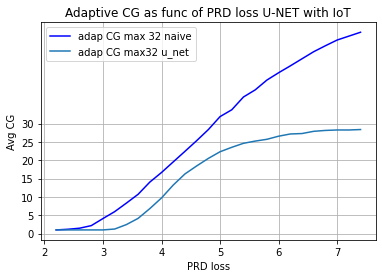

In [32]:
plt.plot(np.arange(2.2,7.5,0.2),adap_cg_min1_max32['cg'],'b')
# plt.plot(np.arange(2.2,7.5,0.2),adap_cg_min1_max32_unet['cg'],'r')
# plt.plot(np.arange(2.2,7.5,0.2),adap_cg_min1_max32_unet_iot['cg'],'y')
# plt.plot(np.arange(2,10,0.2),adap_cg_min1_max64['cg'],'y')
# plt.plot(np.arange(2,10,0.2),static_SOTA_16['cg'],'m')
plt.plot(np.arange(2.2,7.5,0.2),static_SOTA_32['cg'])
# plt.plot(np.arange(2,10,0.2),static_SOTA_64['cg'])
plt
plt.legend(['adap CG max 32 naive','adap CG max32 u_net','adap CG max32 u_net-iot','static CG=32','static CG=64'])
plt.yticks(np.arange(0, 35, 5))
plt.xlabel('PRD loss')
plt.ylabel('Avg CG')
plt.grid()
plt.title('Adaptive CG as func of PRD loss U-NET with IoT')

In [ ]:
plt.scatter(adap_cg_min1_max32['prd'],adap_cg_min1_max32['cg'],c=adap_cg_min1_max32['REALPRD'],marker='^')
plt.scatter(static_SOTA_16['prd'],static_SOTA_16['cg'],c=static_SOTA_16['REALPRD'],marker='o')
plt.scatter(static_SOTA_32['prd'],static_SOTA_32['cg'],c=static_SOTA_32['REALPRD'],marker='|')
plt.legend(['adap CG','static CG=16','static CG=32'])
plt.xlabel('PRD loss')
plt.ylabel('CG')
plt.grid()
plt.title('Adaptive CG as func of PRD loss')

In [ ]:
# def adaptive_compression(df, threshold_PRD,base_factor=1):
#     df_threshold = df[df['PRD']<threshold_PRD]
#     indices = df_threshold.groupby('signal_idx',sort=False)['CG_int'].transform(max)==df_threshold['CG_int']
    
# #     if len(indices)==0:
# #         num_satisfied_PRD_indices = 0
# #         avg_prd = 0
# #         meanCG = base_factor

# #     else:
# #         num_satisfied_PRD_indices = indices.value_counts()[True]
# #         avg_prd = (num_satisfied_PRD_indices/x_test.shape[0])*df_threshold[indices]['PRD'].mean()
# #         meanCG = ((x_test.shape[0]-num_satisfied_PRD_indices)/x_test.shape[0])*base_factor + (num_satisfied_PRD_indices/x_test.shape[0])*df_threshold[indices]['CG_int'].mean()
    
#     return indices


# static_SOTA_64={'prd':[],'cg':[]}
# static_SOTA_32={'prd':[],'cg':[]}
# static_SOTA_16={'prd':[],'cg':[]}
# adap_cg_min1 = {'prd':[],'cg':[]}
# # adap_cg_min32 = []
# for PRD in np.arange(2,10,0.2):
#     static_SOTA_16['cg'].append(adaptive_compression(df[df['CG_int']==16],PRD,1)[1])
#     static_SOTA_32['cg'].append(adaptive_compression(df[df['CG_int']==32],PRD,1)[1])
#     static_SOTA_64['cg'].append(adaptive_compression(df[df['CG_int']==64],PRD,1)[1])
#     adap_cg_min1['cg'].append(adaptive_compression(df,PRD,1)[1])

In [ ]:
def missing_values(df, col_name,upper_value):
    missing_values = []
    unique_values=df[col_name].unique()
    for i in range(upper_value):
        if not i in unique_values:
            missing_values.append(i)
    return missing_values

# len(missing_values(t,'signal_idx',4640))

In [ ]:
def buid_dataset(df,threshold_PRD):

    df_threshold = df[(df['PRD']<threshold_PRD)]
    indices = df_threshold.groupby('signal_idx',sort=False)['CG_int'].transform(max)==df_threshold['CG_int']
    t = df_threshold[indices][['signal_idx','PRD','CG_int']]

    no_compression_idx = missing_values(t,'signal_idx',int(df.shape[0]/3))
    no_compression_stats = pd.DataFrame([[x,0,1] for x in no_compression_idx])
    no_compression_stats.columns = ['signal_idx','PRD','CG_int']
    t = pd.concat([no_compression_stats,t],axis=0)
#     print(t.shape)
    t['MAX_PRD'] = t['CG_int'].apply(lambda x: float(threshold_PRD))
    return t

t = buid_dataset(df,3)
for PRD_run in np.arange(3.2,9,0.2):
#     df_threshold = df[(df['PRD']<PRD) & (df['CG_int']<64)]
#     indices = df_threshold.groupby('signal_idx',sort=False)['CG_int'].transform(max)==df_threshold['CG_int']
#     temp = df_threshold[indices][['signal_idx','PRD','CG_int']]
#     temp['MAX_PRD'] = pd.Series(np.ones(x_train.shape[0])*PRD)
    tempo = buid_dataset(df[df['CG_int']<64],PRD_run)
    t = pd.concat([tempo,t])
    print(t.shape)
#     raise
    

In [ ]:
model_u_net.layers[4].layers[-2].summary()

In [ ]:
t.describe()

In [ ]:
#t[(t['MAX_PRD']>=6.6) & (t['MAX_PRD']<=6.9)]

In [ ]:
t['MAX_PRD'].unique()

In [ ]:
t

In [ ]:
t.describe(include='all')

In [ ]:
df_threshold[indices]

In [ ]:
t.to_csv('Data/compressor_decsision_max32.csv')